<a href="https://colab.research.google.com/github/subaru9/ml-notebooks/blob/main/cv/classification/rd-fp-planes-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Input, MaxPooling2D, BatchNormalization
from tensorflow.keras import Model

from matplotlib import pyplot as plt

from time import time

#### Fixing random seed

In [59]:
# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed

random_state = 42
seed(random_state)
set_seed(random_state)

In [60]:
import pprint
pp = pprint.PrettyPrinter(indent=2)
np.set_printoptions(precision=3, suppress=True, threshold=None, edgeitems=3)

# Dataset

This is a subset of military air planes [dataset](https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset) representing russian aircrafts as well as one sample of US plane. The images cropped from the original dataset images according to the bounding box annotations and is specifically prepared to facilitate the easy training of classification models.

In [61]:
from google.colab import drive
drive.mount('/content/drive');

dataset_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/military-air-planes"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
if os.path.exists(dataset_folder):
    files_in_directory = os.listdir(dataset_folder)
    if files_in_directory == ['mil-planes.tar.gz']:
        os.chdir(dataset_folder)
        !tar -xzf mil-planes.tar.gz && echo "Extraction successful. Files have been unpacked."
    else:
        print("The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.")
else:
    print(f"Directory {dataset_folder} does not exist.")

The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.


## Data Inspection

In [63]:
path = os.path.join(dataset_folder, 'mil-planes.csv')
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3384 entries, 0 to 3383
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      3384 non-null   object
 1   category  3384 non-null   object
 2   class_id  3384 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 79.4+ KB


In [64]:
df.category.unique()

array(['tu95', 'tu160', 'su57', 'su34', 'su25', 'su24', 'mig31', 'f16'],
      dtype=object)

In [65]:
df.category.describe()

count     3384
unique       8
top        f16
freq      1366
Name: category, dtype: object

f16 is the most frequent category with almost the half of the planes, looks like dataset is imbalanced

In [66]:
df.class_id.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [67]:
df.class_id.info(verbose=True)

<class 'pandas.core.series.Series'>
RangeIndex: 3384 entries, 0 to 3383
Series name: class_id
Non-Null Count  Dtype
--------------  -----
3384 non-null   int64
dtypes: int64(1)
memory usage: 26.6 KB


In [68]:
df.head()

,path,category,class_id
0,6b2f847b63922d79120334329c0ca396_1.jpg,tu95,0
1,c49d9a8f5a26485ba0bdd0fa4c32ab9b_0.jpg,tu95,0
2,953a151c55c845dfd28658f43e8d3976_0.jpg,tu95,0
3,27ee17e2c031ca3c0cf5553b6c0b52f0_1.jpg,tu95,0
4,8dcc17cbd5ec25df1c64990a6b130695_2.jpg,tu95,0


In [69]:
df.tail()

,path,category,class_id
3379,4573b545f600572b60d2bd35fbf61a03_1.jpg,f16,7
3380,efd8a5bd1d03a71d4db28e313a3f62ce_1.jpg,f16,7
3381,f164b6193b9d4f3ecf8c8e0f234ce066_3.jpg,f16,7
3382,c7ec7b660ede88aca9a63f90ae531806_5.jpg,f16,7
3383,4fa8bb46e75938624bfc50233c29c3ff_1.jpg,f16,7


### Visualization

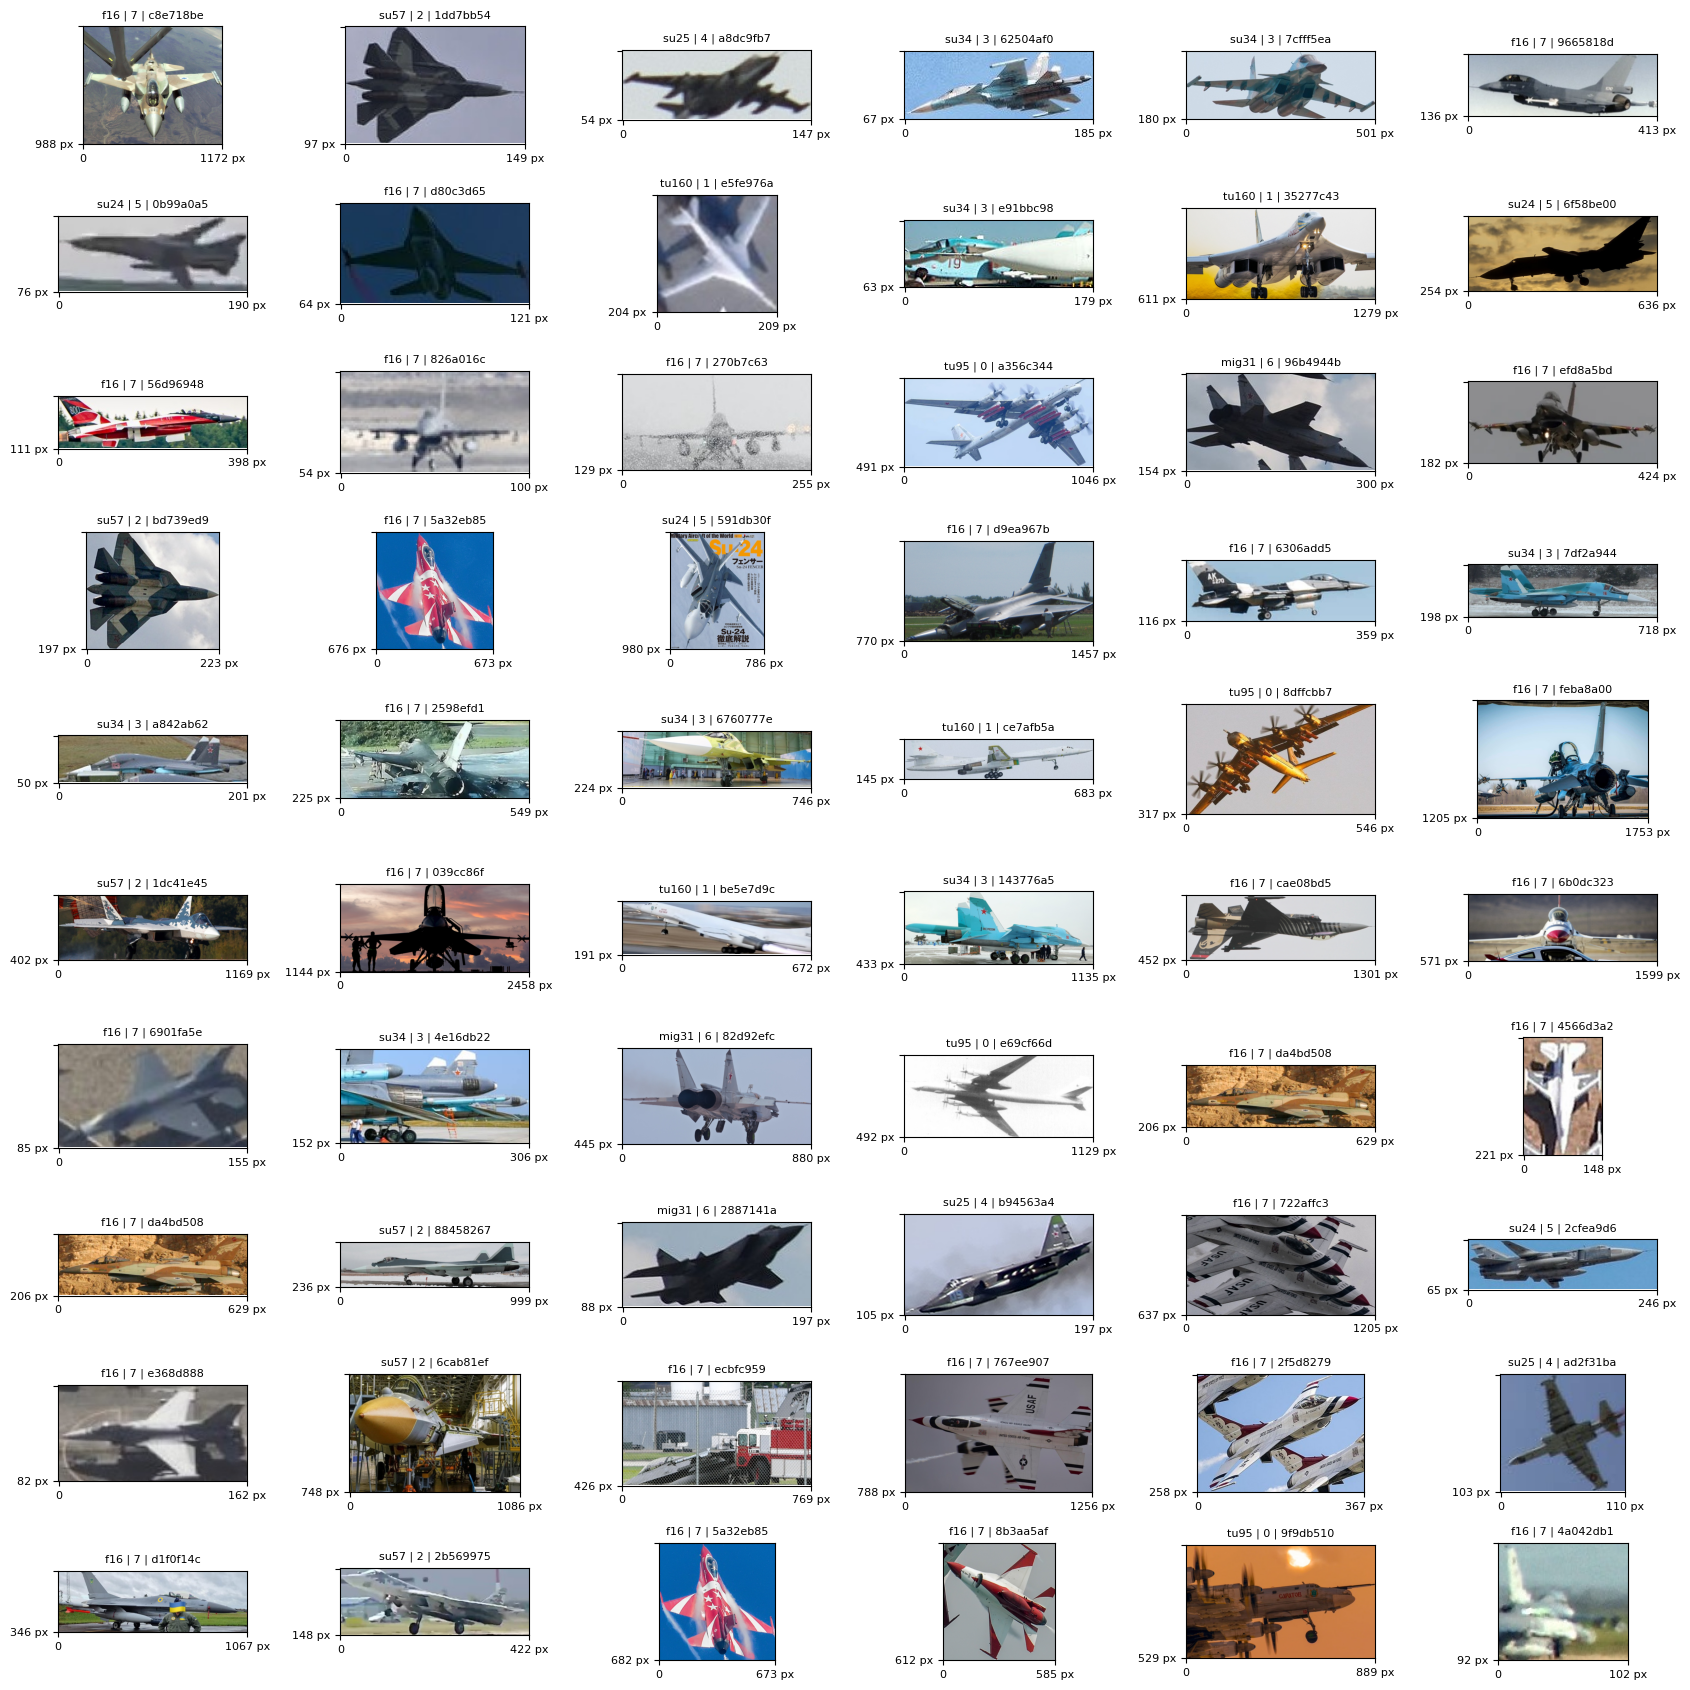

In [70]:
def visualize_images(df, dataset_folder, nrows=10, ncols=6):
    """
    Visualize random images from a dataset with titles indicating class name, class ID, and filename.

    Parameters:
    - df: DataFrame containing 'path', 'category', and 'class_id' columns.
    - dataset_folder: Path to the directory containing the images.
    - nrows: Number of rows in the subplot grid.
    - ncols: Number of columns in the subplot grid.
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(17, 17))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for ax in axes.flat:
        if df.shape[0] > 0:
            idx = np.random.randint(0, len(df))
            row = df.iloc[idx]

            class_id = row['class_id']
            class_name = row['category']
            short_filename = row['path'][:8]
            ax.set_title(f"{class_name} | {class_id} | {short_filename}", fontsize=8)

            path = os.path.join(dataset_folder, row['path'])
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)

            # Set coordinates to start from the left bottom corner
            ax.set_xticks([0, img.shape[1]])
            ax.set_yticks([0, img.shape[0]])

            # Set labels for the axis in pixels
            ax.set_xticklabels(['0', f'{img.shape[1]} px'], fontsize=8)
            ax.set_yticklabels(['', f'{img.shape[0]} px'], fontsize=8)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(df, dataset_folder)

Counter({'f16': 1366, 'su34': 381, 'mig31': 375, 'su57': 329, 'tu160': 278, 'tu95': 271, 'su24': 221, 'su25': 163})


(Text(0.5, 0, 'category'), Text(0, 0.5, 'count'))

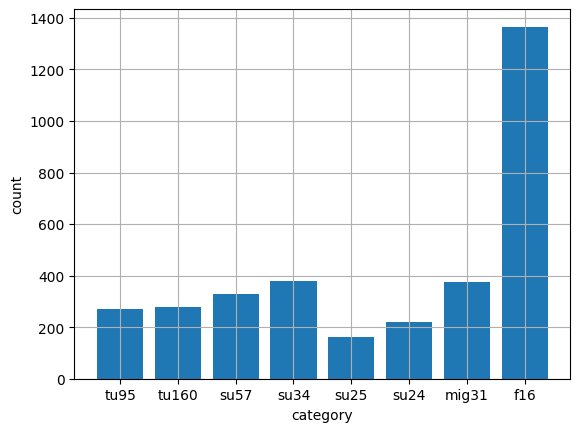

In [71]:
from collections import Counter
hist = Counter(df['category'])
print(hist)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('category'), plt.ylabel('count')

In [72]:
def calculate_brightness(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray)

brightness_per_class = {}
class_ids = df['class_id'].unique()
for class_id in class_ids:
    current_class_filter = df['class_id'] == class_id
    paths = df[current_class_filter]['path']
    brightnesses = [calculate_brightness(os.path.join(dataset_folder, path)) for path in paths]
    brightness_per_class[class_id] = np.mean(brightnesses)

(Text(0.5, 0, 'Classes ID'), Text(0, 0.5, 'Brightness'))

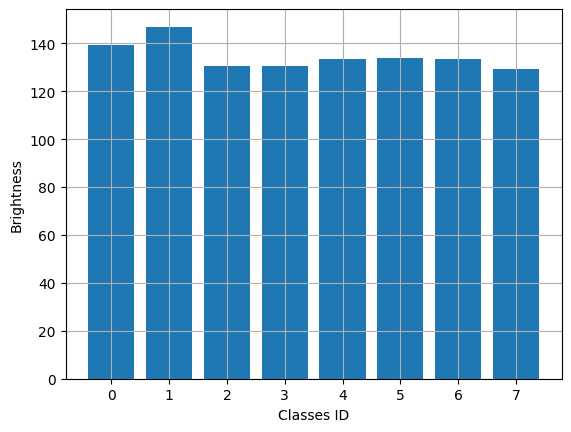

In [73]:
plt.bar(brightness_per_class.keys(), brightness_per_class.values()), plt.grid(True)
plt.xlabel('Classes ID'), plt.ylabel('Brightness')

In [74]:
def calculate_average_image_size(df, dataset_folder):
    sizes = []

    for path in df['path']:
        image_path = os.path.join(dataset_folder, path)
        image = cv2.imread(image_path)

        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            sizes.append(image.shape)

    average_height = np.mean([size[0] for size in sizes])
    average_width = np.mean([size[1] for size in sizes])

    return average_width, average_height

average_width, average_height = calculate_average_image_size(df, dataset_folder)
print(f"Average width: {average_width}, Average height: {average_height}")

Average width: 608.6852836879433, Average height: 318.3637706855792


## Data preparation

In [75]:
from sklearn.model_selection import train_test_split

train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=random_state)
test_df

,path,category,class_id
402,8d12a7e3a53f0570ee57c75f99b7b3d0_0.jpg,tu160,1
321,aef1f7cf46dc2d9f922b68a64a978f2d_1.jpg,tu160,1
457,f3761eb5c7a4846a1be26ce87c6ec18d_0.jpg,tu160,1
879,ea8b6486438a46e285ab73a1a400c021_0.jpg,su34,3
2044,4566d3a226f58658aafa34b6a03b75d4_23.jpg,f16,7
...,...,...,...
3125,33c5fbff8bea07cc7f63cd3b120be9b5_0.jpg,f16,7
259,2626b1bff5cab98b008827bcee2e508d_0.jpg,tu95,0
2140,84510c0f162f4da5bec9ebf77127addb_1.jpg,f16,7
1626,3cdd008c4f6628b6cd4837323c1163c7_1.jpg,su24,5


In [76]:
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=random_state)
train_df

,path,category,class_id
2280,01742519344097097dd43a29597b885d_0.jpg,f16,7
3203,49311eb4ed682df188c374fc60bbe83e_1.jpg,f16,7
638,c33b2e5d8c6cbf6de7cfa46e7ef3becf_1.jpg,su57,2
3256,ac5e83a9c25695719e743d61c19a1785_0.jpg,f16,7
1384,91bf92c8b78bb7458ea654a933eba8eb_0.jpg,su25,4
...,...,...,...
10,88f2404cff02a00166779ad3652d73c4_0.jpg,tu95,0
2144,729ef184e390c7968221815956f34423_0.jpg,f16,7
2803,b65824ceec072e468548aae35e18142f_3.jpg,f16,7
1403,0055583f8723e234fb5ce74f3df59cf1_0.jpg,su25,4


In [77]:
valid_df

,path,category,class_id
1710,7ecbff1c2622efc7e5c277517e78a3c3_0.jpg,mig31,6
2946,d09cb32c61b4559593b790e0922a70a4_0.jpg,f16,7
1673,8d158dcf70364d69bf9fb7013383cc84_0.jpg,mig31,6
3347,f1adbb639645526bf578f1d00896e2ff_0.jpg,f16,7
2744,59b3bb61752313fc4b41c4873079c7c8_5.jpg,f16,7
...,...,...,...
525,b094b655e40b418b955f83f1c6205215_0.jpg,tu160,1
1373,d012dab162c6e3bd68a3d379c896c248_0.jpg,su25,4
237,ca42d9a019e13bbf2b15144d0667df41_0.jpg,tu95,0
514,5ed043741b5acc904c9e0c44fdb08274_2.jpg,tu160,1


In [78]:
print(f"Total dataset size: {df.shape[0]}")
print(f"Train dataset size: {train_df.shape[0]}")
print(f"Validation dataset size: {valid_df.shape[0]}")
print(f"Test dataset size: {test_df.shape[0]}")

Total dataset size: 3384
Train dataset size: 2030
Validation dataset size: 677
Test dataset size: 677


## Baseline

#### Data preparation and load

In [79]:
def resize_image_with_aspect_ratio(img, target_width, target_height):
    """
    Resize an image to a target size while preserving the aspect ratio.

    Parameters:
    - img: The input image.
    - target_width: The desired width.
    - target_height: The desired height.

    Returns:
    - The resized image with preserved aspect ratio.
    """
    original_height, original_width = img.shape[:2]
    ratio_w = target_width / original_width
    ratio_h = target_height / original_height
    ratio = min(ratio_w, ratio_h)

    new_width = int(original_width * ratio)
    new_height = int(original_height * ratio)

    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Create a new image and place the resized image in the center
    new_img = np.zeros((target_height, target_width, 3), dtype=np.uint8)
    top = (target_height - new_height) // 2
    left = (target_width - new_width) // 2
    new_img[top:top+new_height, left:left+new_width] = resized_img

    return new_img

def load_and_resize_images(df, img_height, img_width, img_dir):
    """
    Load images from a directory and resize them to a target size while preserving the aspect ratio.

    Parameters:
    - df: DataFrame containing the image paths and class IDs.
    - img_height: The desired height of the images.
    - img_width: The desired width of the images.
    - img_dir: Directory containing the images.

    Returns:
    - x_train: Array of resized images.
    - y_train: Array of class IDs.
    """
    x_train = []
    y_train = []

    for _, row in df.iterrows():
        img_path = os.path.join(img_dir, row['path'])
        class_id = row['class_id']

        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        resized_img = resize_image_with_aspect_ratio(img_rgb, img_width, img_height)

        x_train.append(resized_img)
        y_train.append(class_id)

    return np.array(x_train), np.array(y_train)

In [80]:
img_height = 224
img_width = 224

train_df, valid_df

x_train, y_train = load_and_resize_images(train_df, img_height, img_width, dataset_folder)
x_valid, y_valid = load_and_resize_images(valid_df, img_height, img_width, dataset_folder)
x_test, y_test = load_and_resize_images(test_df, img_height, img_width, dataset_folder)

7


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
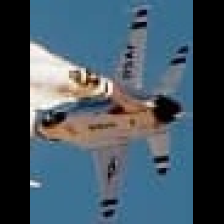

In [81]:
idx = np.random.randint(0, len(x_train))
print(y_train[idx])
x_train[idx]

7


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
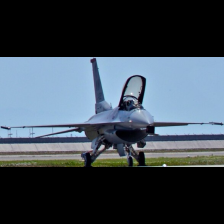

In [82]:
idx = np.random.randint(0, len(x_valid))
print(y_valid[idx])
x_valid[idx]

2


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
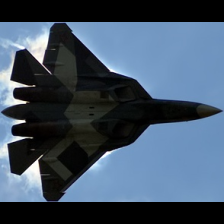

In [83]:
idx = np.random.randint(0, len(x_test))
print(y_test[idx])
x_test[idx]

In [84]:
# Normalization
x_train = x_train/255
x_valid = x_valid/255
x_test = x_test/255

idx = np.random.randint(0, len(x_train))
pp.pprint(x_train[idx][:, :, 0])

array([[0.   , 0.   , 0.592, ..., 0.702, 0.   , 0.   ],
       [0.   , 0.   , 0.596, ..., 0.702, 0.   , 0.   ],
       [0.   , 0.   , 0.596, ..., 0.702, 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.463, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.471, ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.486, ..., 0.   , 0.   , 0.   ]])


In [85]:
print('Train set:   ', len(y_train), 'samples')
print('Valid set:   ', len(y_valid), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    2030 samples
Valid set:    677 samples
Test set:     677 samples
Sample dims:  (2030, 224, 224, 3)


#### Building the Baseline Classifier

In [86]:
input_shape = x_train[0].shape
print(input_shape)
num_classes = 8

inputs = Input(shape=input_shape, name="input_224x224x3")

net = Conv2D(16, kernel_size=(3, 3), activation="relu", padding='same', name="conv2d_16x3x3")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)

net = Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same', name="conv2d_32x3x3")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)

net = Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same', name="conv2d_64x3x3")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Dropout(0.2)(net)

net = Flatten()(net)

net = Dense(256, activation="relu")(net)
net = Dropout(0.5)(net)

outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

(224, 224, 3)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_224x224x3 (InputLaye  [(None, 224, 224, 3)]     0         
 r)                                                              
                                                                 
 conv2d_16x3x3 (Conv2D)      (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 112, 112, 16)      0         
                                                                 
 conv2d_32x3x3 (Conv2D)      (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 56, 56, 3

#### Training the Baseline Classifier

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  horizontal_flip=True,
  rotation_range=10,
  zoom_range=0.1
)


In [88]:
class_counts = train_df['class_id'].value_counts().sort_index()
total_samples = train_df.shape[0]
class_weights = {class_id: total_samples / (num_classes * count)
                 for class_id, count in class_counts.items()}
print(class_weights)

{0: 1.7744755244755244, 1: 1.5472560975609757, 2: 1.2378048780487805, 3: 1.122787610619469, 4: 2.393867924528302, 5: 2.063008130081301, 6: 1.1481900452488687, 7: 0.30136579572446553}


In [89]:
epochs = 90
batch_size = 64

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
start = time()
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                   class_weight=class_weights,
                   epochs=epochs,
                   validation_data=(x_valid, y_valid))

print('Elapsed time', time() - start)

Epoch 1/90
32/32 [==============================] - 21s 620ms/step - loss: 2.5621 - accuracy: 0.2512 - val_loss: 2.0712 - val_accuracy: 0.2482
Epoch 2/90
32/32 [==============================] - 20s 612ms/step - loss: 2.0580 - accuracy: 0.2882 - val_loss: 2.0483 - val_accuracy: 0.1507
Epoch 3/90
32/32 [==============================] - 20s 614ms/step - loss: 2.0228 - accuracy: 0.2202 - val_loss: 2.0162 - val_accuracy: 0.1920
Epoch 4/90
32/32 [==============================] - 20s 618ms/step - loss: 1.9874 - accuracy: 0.2094 - val_loss: 1.9796 - val_accuracy: 0.2171
Epoch 5/90
32/32 [==============================] - 20s 617ms/step - loss: 1.9553 - accuracy: 0.2015 - val_loss: 1.9902 - val_accuracy: 0.1905
Epoch 6/90
32/32 [==============================] - 20s 616ms/step - loss: 1.9152 - accuracy: 0.2163 - val_loss: 1.9331 - val_accuracy: 0.2496
Epoch 7/90
32/32 [==============================] - 20s 612ms/step - loss: 1.8797 - accuracy: 0.2389 - val_loss: 1.8846 - val_accuracy: 0.2644

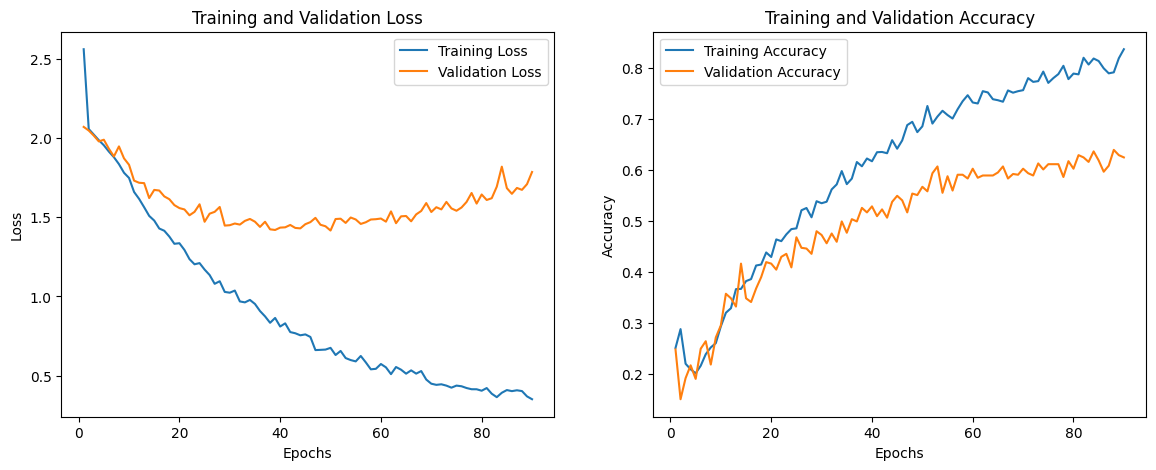

In [90]:
def plot_training_history(history, epochs_range):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Loss plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history, range(1, epochs + 1))

#### Baseline Evaluation

In [91]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

22/22 [==============================] - 0s 8ms/step - loss: 1.5051 - accuracy: 0.6588
Test Loss: 1.5051
Test Accuracy: 0.6588
